# Location selection demo

In [1]:

import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

plt.ion()

n = 20


## Helper functions

In [2]:

def generate_cities(n, seed):
    random.seed(seed)
    # Generate n cities with random coordinates
    cities = [(random.uniform(0, 100), random.uniform(0, 100)) for _ in range(n)]
    return cities

def calculate_distance(city1, city2):
    # Calculate Euclidean distance between two cities
    return np.sqrt((city1[0] - city2[0]) ** 2 + (city1[1] - city2[1]) ** 2)

def create_popuations(n):
    populations = np.array([(random.triangular(-1, 1)**2)*1000 for _ in range(n)]).round() * 100
    return populations


def create_adjacency_matrix(cities):
    n = len(cities)
    adjacency_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i != j:
                adjacency_matrix[i][j] = calculate_distance(cities[i], cities[j])
    
    return adjacency_matrix

def plot_cities(cities, marker_downscale_factor):

    margin = 0.05

    # Plot the cities on a Cartesian coordinate system
    city_coords = cities.loc[:,["lat", "long"]].values
    x_coords, y_coords = zip(*city_coords)

    plt.figure(figsize=(8, 8))
    plt.scatter(x_coords, y_coords, color='blue', s=cities.loc[:,"pop"]/marker_downscale_factor)
    
    for idx, city in cities.iterrows():
        plt.annotate(city["city"], (city["lat"], city["long"]), textcoords="offset points", xytext=(0,10), ha='center')


    min_x = min(x_coords) - margin
    max_x = max(x_coords) + margin
    min_y = min(y_coords) - margin
    max_y = max(y_coords) + margin

    plt.title('Mobile Clinic Service Region')
    plt.xlabel('Lat')
    plt.ylabel('Long')
    plt.xlim(min_x, max_x)
    plt.ylim(min_y, max_y)
    plt.grid()
    plt.show()


## Setting up data

In [13]:

from slugify import slugify

def no_nan(val):
    if pd.isna(val):
        return ""
    else:
        return str(val)

cities = pd.read_csv("cities.csv")
sites = pd.read_csv("sites.csv")


events = pd.merge(cities,sites,on="city")
events.loc[:,"expectedAttendance"] = events.loc[:,"pop"] * events.loc[:,"attendanceRate"]

events.loc[:, "event_id"] = events.apply(lambda row: slugify(f'{row["city"]} {row["site"]} {no_nan(row["event"])}'), axis=1)

events

,city,lat,long,pop,site,event,attendanceRate,expectedAttendance,event_id
0,Lima,40.746389,-84.123333,35579,Mercy Health Thrift,NaN,0.002,71.158,lima-mercy-health-thrift
1,Lima,40.746389,-84.123333,35579,Habitat For Humanity,NaN,0.002,71.158,lima-habitat-for-humanity
2,Lima,40.746389,-84.123333,35579,Our Daily Bread,NaN,0.002,71.158,lima-our-daily-bread
3,Lima,40.746389,-84.123333,35579,St. Mark’s Methodist,Community Meal,0.002,71.158,lima-st-marks-methodist-community-meal
4,Lima,40.746389,-84.123333,35579,Christian Corner Community Center,NaN,0.002,71.158,lima-christian-corner-community-center
5,Kenton,40.646667,-83.622500,7947,Seton Hall,NaN,0.002,15.894,kenton-seton-hall
6,Kenton,40.646667,-83.622500,7947,Hardincrest,NaN,0.002,15.894,kenton-hardincrest
7,Kenton,40.646667,-83.622500,7947,YMCA,NaN,0.002,15.894,kenton-ymca
8,Bluffton,40.889444,-83.879167,3967,Bluffton Public Library,NaN,0.002,7.934,bluffton-bluffton-public-library
9,Alger,40.709722,-83.844167,837,Community Center,Food Commodities,0.002,1.674,alger-community-center-food-commodities


## Plot city

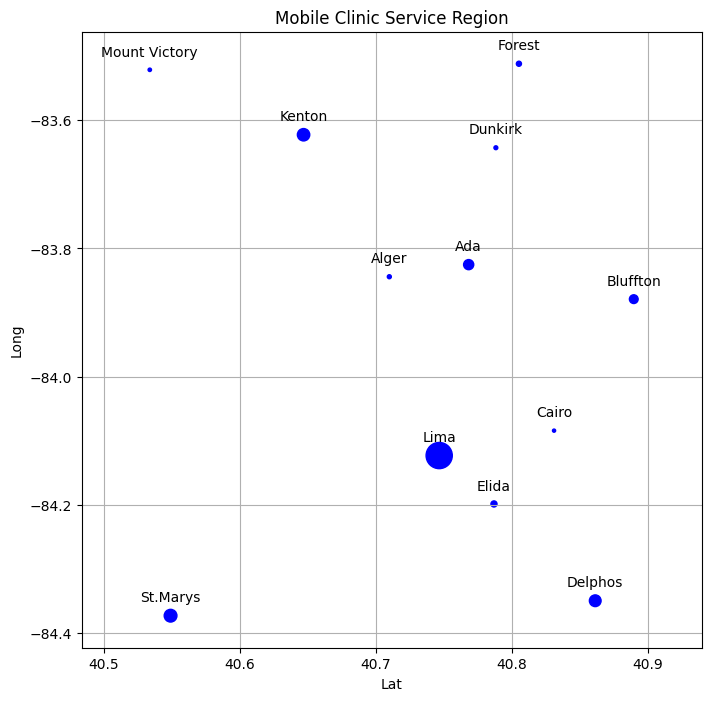

In [14]:
%matplotlib inline 
city_coords = cities.loc[:, ["lat","long"]].values

adjacency_matrix = create_adjacency_matrix(city_coords)

marker_downscale_factor = 100

plot_cities(cities, marker_downscale_factor)
#plot_cities(cities)


## Representation of problem

In [40]:
from pymoo.core.problem import Problem
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga3 import NSGA3

class clinicOptimization(Problem):

    def __init__(self, events, max_events, min_atp, home):
        event_n = events.shape[0] 
        super().__init__(n_var=event_n, n_obj=3, n_ieq_constr=1, xl=0, xu=1, vtype=bool)
        self.max_events = max_events
        self.cities = events.loc[:,"city"]
        self.events = events
        self.expectected_attendance = events.loc[:,"expectedAttendance"].values
        self.min_atp = min_atp
        self.home = home



    def _evaluate(self, x, out, *args, **kwargs):
        x_bool = x < 0.5
        np.multiply(x_bool, self.expectected_attendance)

        visited_per_solution = np.multiply(x_bool, self.expectected_attendance )

        # Objective 1: Maximize total population visited 
        total_pop_visited = visited_per_solution.sum(axis=1)

        # Objective 2: Maximize the total number of cities visited 
        #total_cities_visited = self.events.loc[x_bool, "city"].unique().shape[0]
        #total_cities_visited = x_bool.apply_along_axis(lambda row: self.events.loc[x_bool, "city"].unique().shape[0],   axis=1)   
        total_cities_visited = np.apply_along_axis(lambda row: self.events.loc[row, "city"].unique().shape[0], 1, x_bool)

        # Objective 3: Minimize the total number of events that are overstaffed
        overstaffed_events = np.logical_and(visited_per_solution < self.min_atp, visited_per_solution != 0)
        total_overstaffed_events = overstaffed_events.sum(axis=1)

        # Wrap up our objectives all nice and pretty
        out["F"] = np.column_stack([
            -total_pop_visited,              # max
            -total_cities_visited,           # max
            total_overstaffed_events])       # min

        # Constrains: Total cities visited
        out["G"] =  total_cities_visited - self.max_events




## Run optimization

In [41]:

import pandas as pd

# atp = attendees per site 
# (this is just going off of raw pop, though normally we'd want to estimate the total 
# number of visitors per capital)
min_atp = 15

home = np.array([50,50])
prob = clinicOptimization(events, 8, min_atp, home)

ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

algorithm = NSGA3(pop_size=200,
                  ref_dirs=ref_dirs)

res = minimize(prob,
               algorithm,
               ('n_gen', 100),
               verbose=False)


# Get a list of the cities that were visited (decision variables)
locations_visited_bool = res.X < 0.5

locations_visited = []
for lvb in locations_visited_bool: 
    locations_visited.append("\n".join(events.loc[lvb, "event_id"].values))


# Package up the results nicely 
results = pd.DataFrame(res.F, 
                       columns=["Total Patients Served", "Total Cities visited", "Number of over staffed events"])
results.loc[:,"Total Patients Served"] = np.abs(results.loc[:,"Total Patients Served"])
results.loc[:,"Total Cities visited"] = np.abs(results.loc[:,"Total Cities visited"])
results.loc[:,"Visited cities"] = locations_visited

results

,Total Patients Served,Total Cities visited,Number of over staffed events,Visited cities
0,416.302,5.0,4.0,lima-mercy-health-thrift\nlima-habitat-for-hum...
1,414.628,5.0,3.0,lima-mercy-health-thrift\nlima-habitat-for-hum...
2,403.472,2.0,0.0,lima-mercy-health-thrift\nlima-habitat-for-hum...
3,414.754,4.0,3.0,lima-mercy-health-thrift\nlima-habitat-for-hum...
4,413.080,4.0,2.0,lima-mercy-health-thrift\nlima-habitat-for-hum...
5,411.406,3.0,1.0,lima-mercy-health-thrift\nlima-habitat-for-hum...


In [46]:
%matplotlib qt

from mpl_toolkits.mplot3d import Axes3D

x = results.loc[:,"Total Patients Served"]
y = results.loc[:,"Total Cities visited"]
z = results.loc[:,"Number of over staffed events"]

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=z)

ax.set_xlabel("Total patients served")
ax.set_ylabel("Total cities visited")
ax.set_zlabel("Number of overstaffed events")

plt.show()